In [1]:
# import the necessary packages
from scipy.spatial import distance as dist
from collections import OrderedDict
import numpy as np

class CentroidTracker():
    def __init__(self, maxDisappeared=200):
        # initialize the next unique object ID along with two ordered
        # dictionaries used to keep track of mapping a given object
        # ID to its centroid and number of consecutive frames it has
        # been marked as "disappeared", respectively
        self.nextObjectID = 0
        self.objects = OrderedDict()
        self.disappeared = OrderedDict()

        # store the number of maximum consecutive frames a given
        # object is allowed to be marked as "disappeared" until we
        # need to deregister the object from tracking
        self.maxDisappeared = maxDisappeared
    
    def register(self, centroid):
        # when registering an object we use the next available object
        # ID to store the centroid
        self.objects[self.nextObjectID] = centroid
        self.disappeared[self.nextObjectID] = 0
        self.nextObjectID += 1
        
    def deregister(self, objectID):
        # to deregister an object ID we delete the object ID from
        # both of our respective dictionaries
        del self.objects[objectID]
        del self.disappeared[objectID]
        
    def update(self, rects, vects, min_dist):
        # check to see if the list of input bounding box rectangles
        # is empty
        if len(vects) == 0:
            # loop over any existing tracked objects and mark them
            # as disappeared
            for objectID in self.disappeared.keys():
                self.disappeared[objectID] += 1
 
                # if we have reached a maximum number of consecutive
                # frames where a given object has been marked as
                # missing, deregister it
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
 
            # return early as there are no centroids or tracking info
            # to update
            return self.objects
        
        # initialize an array of input centroids for the current frame
        inputDetections = np.zeros((len(vects), len(vects[0])), dtype="int") #NEW 2:=len(vects[0])
 
        # loop over the bounding box rectangles
        #for (i, (startX, startY, endX, endY)) in enumerate(rects):
        #Changed coordinates
        for i  in range(len(vects)):
            # use the bounding box coordinates to derive the centroid
            #cX = int((startX + endX) / 2.0)
            #cY = int((startY + endY) / 2.0)
            inputDetections[i] = vects[i] #New (CX, cy):=vects[i]
            
        # if we are currently not tracking any objects take the input
        # detection and register each of them
        if len(self.objects) == 0:
            for i in range(0, len(inputDetections)):
                self.register(inputDetections[i])
                
        # otherwise, we are currently tracking objects so we need to
        # try to match the input centroids to existing object
        # centroids
        else:
            # grab the set of object IDs and corresponding centroids
            objectIDs = list(self.objects.keys())
            objectCentroids = list(self.objects.values())
 
            # compute the distance between each pair of object
            # centroids and input detection, respectively -- our
            # goal will be to match an input detection to an existing
            # object centroid
            D = dist.cdist(np.array(objectCentroids), inputDetections, 'euclidean')
            row_max = D.max(axis=1)
            maxim=max(row_max)
            D = D / maxim
            # in order to perform this matching we must (1) find the
            # smallest value in each row and then (2) sort the row
            # indexes based on their minimum values so that the row
            # with the smallest value is at the *front* of the index
            # list
            rows = D.min(axis=1).argsort()
 
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
            cols = D.argmin(axis=1)[rows]
            
            s=[]
            #for (row, col) in zip(rows, cols):
            for z in range(len(rows)):
                if D[rows[z]][cols[z]]>min_dist:
                #print(row, col, D[row][col])
                    s.append(z)
            rows=np.delete(rows,s)
            cols=np.delete(cols, s)
            
            
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
            usedRows = set()
            usedCols = set()
 
            # loop over the combination of the (row, column) index
            # tuples
            for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
                if row in usedRows or col in usedCols:
                    continue
 
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
                objectID = objectIDs[row]
                self.objects[objectID] = inputDetections[col]
                self.disappeared[objectID] = 0
 
                # indicate that we have examined each of the row and
                # column indexes, respectively
                usedRows.add(row)
                usedCols.add(col)
                
            # compute both the row and column index we have NOT yet
            # examined
            unusedRows = set(range(0, D.shape[0])).difference(usedRows)
            unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            
            # in the event that the number of object centroids is
            # equal or greater than the number of input detections
            # we need to check and see if some of these objects have
            # potentially disappeared
            #if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
            for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
                objectID = objectIDs[row]
                self.disappeared[objectID] += 1
 
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
                if self.disappeared[objectID] > self.maxDisappeared:
                    self.deregister(objectID)
                        
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input detection as a trackable object
            #else:
            for col in unusedCols:
                self.register(inputDetections[col])
 
        # return the set of trackable objects
        return self.objects

In [2]:
def get_propper_transform(x, boxIII, boxI):
    if x>boxIII[0][0]:
        M_prop=M3
    elif x<boxI[1][0]:
        M_prop=M1
    else:
        M_prop=M2
    return M_prop

In [46]:
bboxI=np.array([[  8,   5,  14,   8],
       [316,   5,   8,   8],
       [316, 522,   8,   6],
       [  8, 522,  12,  10]]).astype(int)
                
                
bboxII=np.array([[322,   5,   8,   8],
       [632,   5,   6,  10],
       [632, 522,  10,  14],
       [322, 522,   8,  12]]).astype(int)
                
bboxIII=np.array([[640,   5,  10,  10],
       [950,   5,  10,   8],
       [950, 522,  10,  10],
       [640, 522,  10,  10]]).astype(int)

In [47]:
bboxI_tr=np.array([[303,  52,   6,   8],
       [590,  52,  10,  10],
       [466, 504,   8,   8],
       [265, 504,   8,   8]]).astype(int)
                
                
bboxII_tr=np.array([[  0,  52,  12,   8],
       [294,  52,  12,  10],
       [262, 504,   8,   8],
       [102, 504,   8,  12]]).astype(int)
                
bboxIII_tr=np.array([[598,  52,  14,  12],
       [889,  52,  12,   8],
       [588, 504,  14,   8],
       [465, 504,  14,  10]]).astype(int)

In [48]:
M1 = cv2.getPerspectiveTransform(np.float32(bboxI[:,0:2]), np.float32(bboxI_tr[:,0:2]))
M2 = cv2.getPerspectiveTransform(np.float32(bboxII[:,0:2]),np.float32(bboxII_tr[:,0:2]))
M3 = cv2.getPerspectiveTransform(np.float32(bboxIII[:,0:2]),np.float32(bboxIII_tr[:,0:2]))

In [49]:
# import the necessary packages
import numpy as np
from matplotlib import pyplot as plt
import argparse
import imutils
import time
import cv2
import os
from datetime import datetime
import seaborn as sns

# construct the argument parse and parse the arguments
confidence_cutoff = 0.3 
thrsh=0.3 
min_dist=0.2

'''ap.add_argument("-t", "--threshold", type=float, default=0.3,
    help="threshold when applyong non-maxima suppression")
args = vars(ap.parse_args())'''

# load the COCO class labels our YOLO model was trained on
labelsPath ='/home/zamarseny/darknet/data/coco.names'#labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")
 
# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
    dtype="uint8")

frm_nmb=0
start_time=datetime.now()

alpha_tr=0.1 #range(0., 0.5) Less alpha - bigger tracking window. 2*alpha_tr*100 percent of image will be cut off

# derive the paths to the YOLO weights and model configuration
weightsPath ='/home/zamarseny/darknet/yolov3.weights'#weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath ='/home/zamarseny/darknet/cfg/yolov3.cfg'#configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])
 
# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

ct = CentroidTracker()

#hog = cv2.HOGDescriptor()

# initialize the video stream, pointer to output video file, and
# frame dimensions
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/MOT_Challenge_Visualize.mp4')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/3_cams/3_cams.mp4')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/test_multicamera.avi')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/Skolkovo6x640x480.avi')
#vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/vertical_panorama.avi')
vs=cv2.VideoCapture('/home/zamarseny/Data_Science/input_data/test_multicamera_MOT.avi')
writer = None
(W, H) = (None, None)
 
# try to determine the total number of frames in the video file
try:
    prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
        else cv2.CAP_PROP_FRAME_COUNT
    total = int(vs.get(prop))
    print("[INFO] {} total frames in video".format(total))
 
# an error occurred while trying to determine the total
# number of frames in the video file
except:
    print("[INFO] could not determine # of frames in video")
    print("[INFO] no approx. completion time can be provided")
    total = -1

# loop over frames from the video file stream
while vs.isOpened():
    # read the next frame from the file
    (grabbed, frame1) = vs.read()
    #frame1=frame.copy()
    double=frame1*0
    # if the frame was not grabbed, then we have reached the end
    # of the stream
    if not grabbed:
        break
 
    # if the frame dimensions are empty, grab them
    if W is None or H is None:
        (H, W) = frame1.shape[:2]

    # construct a blob from the input frame and then perform a forward
    # pass of the YOLO object detector, giving us our bounding boxes
    # and associated probabilities
    blob = cv2.dnn.blobFromImage(frame1, 1 / 255.0, (416, 416),
        swapRB=True, crop=False)
    net.setInput(blob)
    start = time.time()
    layerOutputs = net.forward(ln)
    end = time.time()
 
    # initialize our lists of detected bounding boxes, confidences,
    # and class IDs, respectively
    boxes = []
    confidences = []
    classIDs = []
    rects=[]
    vects=[]
    
    # loop over each of the layer outputs
    for output in layerOutputs:
        # loop over each of the detections
        for detection in output:
            # extract the class ID and confidence (i.e., probability)
            # of the current object detection
            scores = detection[5:]
            classID = np.argmax(scores)
            confidence = scores[classID]
 
            # filter out weak predictions by ensuring the detected
            # probability is greater than the minimum probability
            if confidence > confidence_cutoff and classID==0:#if confidence > args["confidence"]:
                # scale the bounding box coordinates back relative to
                # the size of the image, keeping in mind that YOLO
                # actually returns the center (x, y)-coordinates of
                # the bounding box followed by the boxes' width and
                # height
                box = detection[0:4] * np.array([W, H, W, H])
                
                #Cropping BB
                box=np.array([box[0],\
                            box[1],\
                            box[2]*(1-alpha_tr),\
                            box[3]*(1-alpha_tr),\
                             ])
                (centerX, centerY, width, height) = box.astype("int")
 
                # use the center (x, y)-coordinates to derive the top
                # and and left corner of the bounding box
                x = int(centerX - (width / 2))
                y = int(centerY - (height / 2))
 
                # update our list of bounding box coordinates,
                # confidences, and class IDs
                boxes.append([x, y, int(width), int(height)])
                confidences.append(float(confidence))
                classIDs.append(classID)
                
    # apply non-maxima suppression to suppress weak, overlapping
    # bounding boxes
    idxs = cv2.dnn.NMSBoxes(boxes, confidences, confidence_cutoff,#args["confidence"],
        thrsh)#args["threshold"]) ''''''
 
    # ensure at least one detection exists
    if len(idxs) > 0:
        # loop over the indexes we are keeping
        for i in idxs.flatten():
            # extract the bounding box coordinates
            (x, y) = (boxes[i][0], boxes[i][1])
            (w, h) = (boxes[i][2], boxes[i][3])
            
            M=get_propper_transform(int((2*x+w)/2), bboxIII, bboxI)
            x_tr, y_tr= cv2.perspectiveTransform(np.array([[[int((2*x+w)/2), int((y+h))]]], dtype=np.float32), M)[0][0]
 
            # draw a bounding box rectangle and label on the frame
            color = (50, 250, 50)#[int(c) for c in COLORS[classIDs[i]]]
            cv2.rectangle(frame1, (x, y), (x + w, y + h), color, 2)
            #text = "{}: {:.2f}".format(LABELS[classIDs[i]],
            #    confidences[i])
            text = "{:.2f}".format(confidences[i])
            cv2.putText(frame1, text, (x, y - 5),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
            rects.append([x, y, (x+w), (y+h)])
            
            
            #(means, stds) = cv2.meanStdDev(frame[abs(y):(y+h), abs(x):(x+w)])
            #(means, stds) = cv2.meanStdDev(frame[rects[i][1]:rects[i][3], rects[i][0]:rects[i][2]])
            #h1 = hog.compute(frame[abs(y):(y+h), abs(x):(x+w)])
            #hist_of_grad=cv2.calcHist(h1,[0],None,[8],[0, 256])
            #hist_colour=cv2.calcHist(frame[abs(y):(y+h), abs(x):(x+w)],[0, 1, 2],None,[4, 4, 4],[0, 256, 0, 256, 0, 256])
            #vects.append(hist_colour.flatten())
            #vects.append(np.concatenate([means, stds]).flatten())
            vects.append([x_tr, y_tr])
            #vects.append([x, y, (x+w), (y+h)])
            #vects.append(means.flatten())
            #vects.append(cv2.calcHist(frame[abs(y):(y+h), abs(x):(x+w)], [0, 1, 2], None, [3, 3, 3], [0, 256, 0, 256, 0, 256]).ravel())
            
    objects = ct.update(rects, vects, min_dist) #rects
    
    centroids=[]
    centroidIDS=[]
    
    for (objectID, centroid) in objects.items():
        centroids.append(centroid)
        centroidIDS.append(objectID)
    
    if len(objects)==1 and len(vects)>0: #Temporary block
        (x, y) = (boxes[0][0], boxes[0][1])
        (w, h) = (boxes[0][2], boxes[0][3])
        print(frm_nmb, centroidIDS[0], x, y, centroid)
        text = "ID {}".format(centroidIDS[0])
        cv2.putText(frame1, text, (int((2*x+w)/2) - 10, int((2*y+h)/2) - 10),
        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        cv2.circle(frame1, (int((2*x+w)/2), \
                           int((2*y+h)/2)), 6, (0, 0, 255), -1)
    
    
    if len(objects)>1 and len(vects)>1: #NEW
        D1 = dist.cdist(centroids, vects, 'euclidean') #euclidian  cosine
        row_max_D1 = D1.max(axis=1)
        maxim_D1=max(row_max_D1)
        D1 = D1 / maxim_D1
        cols = D1.argmin(axis=1)
        rows = D1.argmin(axis=0)
            
            # loop over the tracked objects
    #counter=0
    #for (objectID, centroid) in objects.items():
        #for counter in cols:
        for counter in range(len(rows)):
        # draw both the ID of the object and the centroid of the
        # object on the output frame
        #(x, y) = (boxes[cols[counter]][0], boxes[cols[counter]][1])
        #(w, h) = (boxes[cols[counter]][2], boxes[cols[counter]][3])
            (x, y) = (rects[counter][0], rects[counter][1])
            (w, h) = (rects[counter][2]-rects[counter][0], rects[counter][3]-rects[counter][1])
            text = "ID {}".format(centroidIDS[rows[counter]])
            cv2.putText(frame1, text, (int((2*x+w)/2) - 10, int((2*y+h)/2) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.circle(frame1, (int((2*x+w)/2), \
                           int((2*y+h)/2)), 6, (0, 0, 255), -1)
            
            #drawing the same on the floor_plan
            M=get_propper_transform(int((2*x+w)/2), bboxIII, bboxI)
            x_tr, y_tr= cv2.perspectiveTransform(np.array([[[int((2*x+w)/2), int((2*y+h)/2)]]], dtype=np.float32), M)[0][0]
            
            cv2.putText(double, text, (int(x_tr)-10, int(y_tr) - 10),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
            cv2.circle(double, (int(x_tr), \
                           int(y_tr)), 6, (0, 0, 255), -1)
        #Temporary fix
            if counter==len(boxes)-1:
                break;
        #counter+=1

    cur_time=datetime.now()#.strftime('%Y-%m-%d %H:%M:%S')
    d=cur_time-start_time
    
    '''   ''' 
    cv2.polylines(frame1,[bboxI[:,0:2]],True,(250,50,50), 3)
    cv2.polylines(frame1,[bboxII[:,0:2]],True,(50,250,50), 3)
    cv2.polylines(frame1,[bboxIII[:,0:2]],True,(250,250,250), 3)
    
    cv2.polylines(double,[bboxI_tr[:,0:2]],True,(250,50,50), 3)
    cv2.polylines(double,[bboxII_tr[:,0:2]],True,(50,250,50), 3)
    cv2.polylines(double,[bboxIII_tr[:,0:2]],True,(250,250,250), 3)
    

    vis=np.concatenate([frame1, double], axis=0)
    cv2.putText(vis, 'frm_nmb: '+str(frm_nmb)+\
                    ' FPS: ' +str("{0:0.1f}".format(frm_nmb/(d.seconds+0.1))) \
                    + 'objects_no'+ str(len(objects))+ 'detections_no' +str(len(vects)) \
                    #+"CPU %: " + str((psutil.cpu_percent())) \
                    #+", frame_N: "+str(frm_nmb)\
                    #+", memory %: " + str(dict(psutil.virtual_memory()._asdict())['percent'])
                    #, (50,425, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (50,50,100), 2);
                    , (int(frame.shape[1]*0.05),int(frame.shape[0]*0.95)), \
                    cv2.FONT_HERSHEY_SIMPLEX, 0.75, (200,50,50), 2);        
    
    #cv2.imshow("Frame", frame) #NEW
    #print(frm_nmb, 'detections_nmb', len(vects), 'objects_no', len(objects))
    cv2.imshow("Frame", cv2.resize(vis, (800,800)))
    
    # check if the video writer is None
    if writer is None:
        # initialize our video writer
        #fourcc = cv2.VideoWriter_fourcc(*"MJPG")
        fourcc = cv2.VideoWriter_fourcc(*"XVID")
        writer = cv2.VideoWriter('output.avi', fourcc, 15,
            (frame.shape[1], frame.shape[0]*2), True)
 
        # some information on processing single frame
        if total > 0:
            elap = (end - start)
            print("[INFO] single frame took {:.4f} seconds".format(elap))
            print("[INFO] estimated total time to finish: {:.4f}".format(
                elap * total))
 
    # write the output frame to disk
    writer.write(vis)
    frm_nmb+=1
    key = cv2.waitKey(1) & 0xFF
 
    # if the `q` key was pressed, break from the loop
    if key == ord("q"):
        break
 
# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()
cv2.destroyAllWindows()

[INFO] loading YOLO from disk...
[INFO] 288 total frames in video
[INFO] single frame took 0.3540 seconds
[INFO] estimated total time to finish: 101.9623


TypeError: unsupported operand type(s) for *: 'NoneType' and 'int'

In [20]:
M

array([[ 9.23047424e-01,  3.52838002e-01, -2.98985461e+02],
       [-3.35526262e-17,  1.64209501e+00,  4.41822168e+01],
       [-4.72432997e-19,  1.51035323e-03,  1.00000000e+00]])

In [28]:
#x,y
np.float32([[x,y]])

array([[505., 209.]], dtype=float32)

In [40]:
x_, y_= cv2.perspectiveTransform(np.array([[[x, y]]], dtype=np.float32), M)[0][0]
#cv2.warpPerspective([[x,y]], M, (960,540))

In [6]:
#box=array([389.00588989, 436.28142357,  90.82736015,  88.34292412])
box=np.array([ 21.01655483, 357.59153366,  38.51372719, 120.93011856])
print(box)
box=np.array([box[0]+(1-alpha_tr)*box[2],\
                            box[1]+(1-alpha_tr)*(box[3]),\
                            box[2]*(1-alpha_tr),\
                            box[3]*(1-alpha_tr),\
             ])
print(box)
#box=array(box[1]+)

[ 21.01655483 357.59153366  38.51372719 120.93011856]
[ 40.27341843 418.05659294  19.25686359  60.46505928]


In [5]:
#print('frame: ',frm_nmb, ', cou: ', counter, len(boxes))
print(' len(cols)', len(cols))
print(cols)
print(' len(vects)', len(vects))
print(vects[0:10])
print(' len(objects)', len(objects))
#objects
box.shape

NameError: name 'cols' is not defined

In [20]:
#centroid
#D
#for (objectID, centroid) in objects.items():
#    print(objectID, centroid)
print(dist.cosine(objects[0], objects[1]))
print(objects[0], objects[1])
#print(np.dot(objects[20], objects[20]))

0.025912896761936532
[228  65 246 111] [487  47 502  86]


In [3]:
#rects
vects

[]

In [4]:
D1[0:10,0:10]
#means.flatten().shape

NameError: name 'D1' is not defined

22 0.0 189 203 8 27
(540, 960, 3) (14, 27, 3)
(array([[123.87218045],
       [144.51503759],
       [166.08270677]]), array([[19.79079057],
       [24.18214403],
       [27.66938133]]))


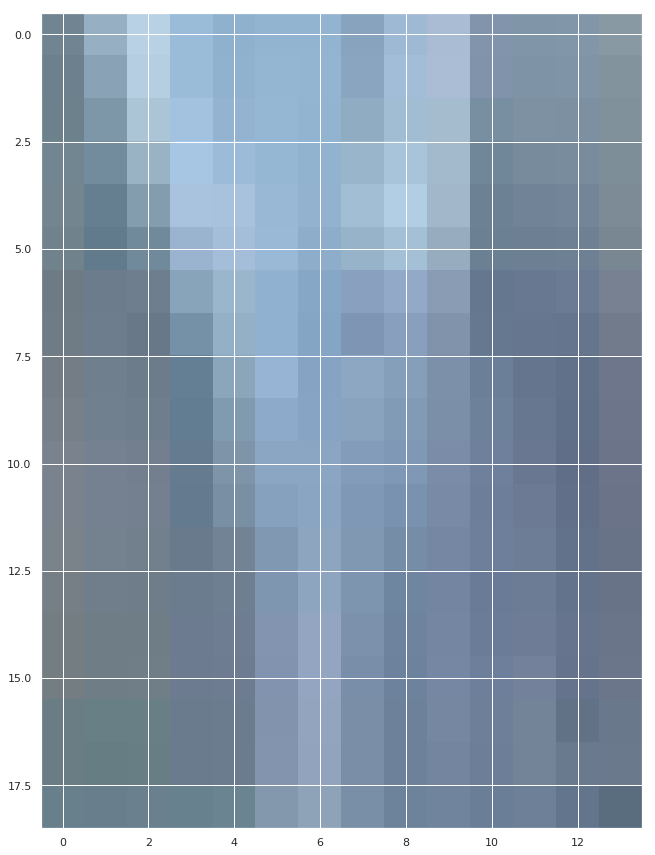

In [23]:
#print(len(classIDs))
(x, y) = (boxes[i][0], boxes[i][1])
(w, h) = (boxes[i][2], boxes[i][3])
print(i, float(confidence), x,(x+w), y,(y+h))
print(frame.shape, frame[x:(x+w), 0:(y+h)].shape)
#plt.imshow(frame[0:(y+h), x:(x+w)])
#plt.imshow(frame[0:38, 510:542])

print(cv2.meanStdDev(frame[y:(y+h), x:(x+w)]))
plt.imshow(frame[abs(y):(y+h), x:(x+w)])

In [6]:
hog = cv2.HOGDescriptor()
#h1 = hog.compute(frame)
img=frame[abs(y):(y+h), x:(x+w)]
h1 = hog.compute(img)
#hist_of_grad=cv2.calcHist(h1,None ,None,[8],[0, 256])

error: OpenCV(4.0.0) /io/opencv/modules/core/src/matrix.cpp:424: error: (-215:Assertion failed) 0 <= _rowRange.start && _rowRange.start <= _rowRange.end && _rowRange.end <= m.rows in function 'Mat'


In [154]:
len(vects)

20

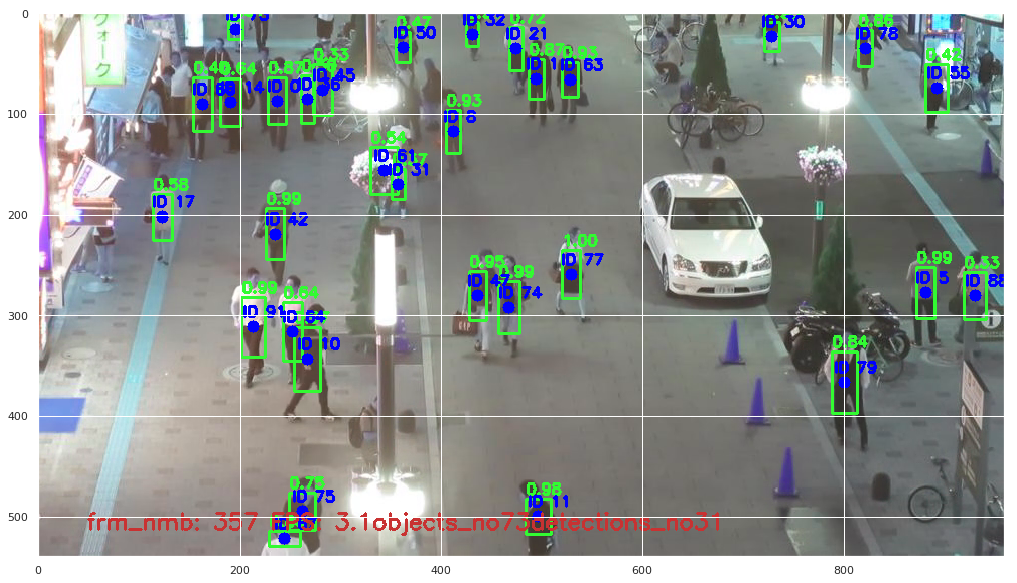

In [24]:
plt.rcParams["figure.figsize"] = (20,10)
plt.imshow(frame1)

In [8]:
len(scores)

80

In [9]:
len(boxes)

33

In [25]:
rects

[[520, 236, 538, 284],
 [226, 195, 244, 245],
 [202, 283, 225, 342],
 [457, 267, 478, 319],
 [872, 253, 890, 304],
 [484, 483, 509, 518],
 [254, 313, 280, 376],
 [428, 257, 445, 306],
 [721, 10, 736, 39],
 [520, 50, 536, 84],
 [405, 97, 419, 140],
 [425, 10, 437, 34],
 [487, 47, 502, 86],
 [228, 65, 246, 111],
 [814, 18, 828, 54],
 [229, 515, 260, 530],
 [788, 337, 813, 398],
 [249, 477, 275, 514],
 [468, 15, 481, 58],
 [181, 66, 201, 113],
 [243, 288, 262, 346],
 [114, 181, 133, 226],
 [330, 134, 357, 181],
 [261, 63, 274, 110],
 [355, 20, 369, 50],
 [881, 52, 903, 99],
 [154, 65, 173, 118],
 [351, 156, 364, 186],
 [273, 52, 292, 102],
 [919, 258, 941, 305],
 [189, 8, 203, 27]]

In [26]:
objects

OrderedDict([(0, array([228,  65, 246, 111])),
             (1, array([487,  47, 502,  86])),
             (2, array([ 56, 218,  70, 247])),
             (4, array([723, 317, 746, 380])),
             (5, array([872, 253, 890, 304])),
             (6, array([ 61, 292,  80, 323])),
             (7, array([421,  65, 434,  88])),
             (8, array([405,  97, 419, 140])),
             (10, array([254, 313, 280, 376])),
             (11, array([484, 483, 509, 518])),
             (14, array([181,  66, 201, 113])),
             (17, array([114, 181, 133, 226])),
             (18, array([147,  78, 160, 121])),
             (21, array([468,  15, 481,  58])),
             (22, array([316, 404, 329, 437])),
             (24, array([432, 192, 448, 214])),
             (25, array([402,  90, 420, 136])),
             (26, array([218,  42, 233,  69])),
             (27, array([375,  71, 391, 122])),
             (28, array([477,  33, 495,  78])),
             (30, array([721,  10, 736,  39])),


In [11]:
print(W, H)

960 540


In [27]:
cou=0
obj=[]
IDS=[]
for (objectID, centroid) in objects.items():
    obj.append(centroid)
    IDS.append(objectID)
    print(objectID, centroid)
    cou+1
    if cou>40:
        break;

0 [228  65 246 111]
1 [487  47 502  86]
2 [ 56 218  70 247]
4 [723 317 746 380]
5 [872 253 890 304]
6 [ 61 292  80 323]
7 [421  65 434  88]
8 [405  97 419 140]
10 [254 313 280 376]
11 [484 483 509 518]
14 [181  66 201 113]
17 [114 181 133 226]
18 [147  78 160 121]
21 [468  15 481  58]
22 [316 404 329 437]
24 [432 192 448 214]
25 [402  90 420 136]
26 [218  42 233  69]
27 [375  71 391 122]
28 [477  33 495  78]
30 [721  10 736  39]
31 [351 156 364 186]
32 [425  10 437  34]
35 [108  91 123 124]
36 [261  63 274 110]
38 [185  39 202 104]
40 [152  89 168 124]
41 [ 44 197  73 240]
42 [226 195 244 245]
43 [275 130 290 151]
45 [273  52 292 102]
47 [428 257 445 306]
48 [426  97 438 121]
50 [355  20 369  50]
51 [627  74 657 113]
52 [384  86 400 138]
53 [168  38 182  71]
55 [881  52 903  99]
58 [613  91 627 129]
59 [349 122 367 153]
60 [291 147 304 176]
61 [330 134 357 181]
62 [413 214 427 252]
63 [520  50 536  84]
64 [243 288 262 346]
65 [276   5 286  21]
66 [154  65 173 118]
67 [229 515 260 530]


In [28]:
obj[0:8]
#print(obj[22:32])

[array([228,  65, 246, 111]),
 array([487,  47, 502,  86]),
 array([ 56, 218,  70, 247]),
 array([723, 317, 746, 380]),
 array([872, 253, 890, 304]),
 array([ 61, 292,  80, 323]),
 array([421,  65, 434,  88]),
 array([405,  97, 419, 140])]

In [29]:
obj[22:32]

[array([425,  10, 437,  34]),
 array([108,  91, 123, 124]),
 array([261,  63, 274, 110]),
 array([185,  39, 202, 104]),
 array([152,  89, 168, 124]),
 array([ 44, 197,  73, 240]),
 array([226, 195, 244, 245]),
 array([275, 130, 290, 151]),
 array([273,  52, 292, 102]),
 array([428, 257, 445, 306])]

In [30]:
min_dist=0.04
objectIDs = IDS[0:8]#[0,1,2]

objectCentroids = obj[0:8]
'''[[2,2],\
                   [7,3],\
                   [6,8]]'''

inputDetections=obj[22:32]
'''[[3,2],\
                 [7,5],\
                 [7,7],\
                 [5,8],\
                 [2,6]]'''
# compute the distance between each pair of object
# centroids and input detection, respectively -- our
# goal will be to match an input detection to an existing
# object centroid
D = dist.cdist(np.array(objectCentroids), inputDetections, 'cosine')

row_max = D.max(axis=1)
maxim=max(row_max)
D = D / maxim

# in order to perform this matching we must (1) find the
# smallest value in each row and then (2) sort the row
# indexes based on their minimum values so that the row
# with the smallest value is at the *front* of the index
# list
rows = D.min(axis=1).argsort()
 
            # next, we perform a similar process on the columns by
            # finding the smallest value in each column and then
            # sorting using the previously computed row index list
cols = D.argmin(axis=1)[rows]  #NEW
            
            # in order to determine if we need to update, register,
            # or deregister an object we need to keep track of which
            # of the rows and column indexes we have already examined
usedRows = set()
usedCols = set()
 
            # loop over the combination of the (row, column) index
            # tuples
print(rows, cols)

s=[]
#for (row, col) in zip(rows, cols):
for i in range(len(rows)):
    if D[rows[i]][cols[i]]>min_dist:
        print(i, D[rows[i]][cols[i]])
        s.append(i)
print(s)
rows=np.delete(rows,s)
cols=np.delete(cols, s)
''''''
print(rows, cols)
            # if we have already examined either the row or
                # column value before, ignore it
                # val    
for (row, col) in zip(rows, cols):
                # if we have already examined either the row or
                # column value before, ignore it
                # val
    if row in usedRows or col in usedCols:
        continue
 
                # otherwise, grab the object ID for the current row,
                # set its new centroid, and reset the disappeared
                # counter
    objectID = objectIDs[row]
#self.objects[objectID] = inputDetections[col]
#self.disappeared[objectID] = 0
 
                # indicate that we have examined each of the row and
                # column indexes, respectively
    usedRows.add(row)
    usedCols.add(col)
                
            # compute both the row and column index we have NOT yet
            # examined
unusedRows = set(range(0, D.shape[0])).difference(usedRows)
unusedCols = set(range(0, D.shape[1])).difference(usedCols)
            
            # in the event that the number of object centroids is
            # equal or greater than the number of input detections
            # we need to check and see if some of these objects have
            # potentially disappeared


'''
if D.shape[0] >= D.shape[1]:
                # loop over the unused row indexes
    for row in unusedRows:
                    # grab the object ID for the corresponding row
                    # index and increment the disappeared counter
        objectID = objectIDs[row]
        self.disappeared[objectID] += 1
 
                    # check to see if the number of consecutive
                    # frames the object has been marked "disappeared"
                    # for warrants deregistering the object
        if self.disappeared[objectID] > self.maxDisappeared:
                        self.deregister(objectID)
                        
            # otherwise, if the number of input centroids is greater
            # than the number of existing object centroids we need to
            # register each new input detection as a trackable object
else:
    for col in unusedCols:
        self.register(inputDetections[col])
 
        # return the set of trackable objects
        return self.objects
'''

[3 7 0 2 4 5 1 6] [7 8 2 5 2 5 0 8]
[]
[3 7 0 2 4 5 1 6] [7 8 2 5 2 5 0 8]


'\nif D.shape[0] >= D.shape[1]:\n                # loop over the unused row indexes\n    for row in unusedRows:\n                    # grab the object ID for the corresponding row\n                    # index and increment the disappeared counter\n        objectID = objectIDs[row]\n        self.disappeared[objectID] += 1\n \n                    # check to see if the number of consecutive\n                    # frames the object has been marked "disappeared"\n                    # for warrants deregistering the object\n        if self.disappeared[objectID] > self.maxDisappeared:\n                        self.deregister(objectID)\n                        \n            # otherwise, if the number of input centroids is greater\n            # than the number of existing object centroids we need to\n            # register each new input detection as a trackable object\nelse:\n    for col in unusedCols:\n        self.register(inputDetections[col])\n \n        # return the set of trackable obje

In [31]:
np.set_printoptions(precision=3)
#print(D)
#for i in range(len(objectCentroids)):
    #for j in range(len(inputDetections)):
        #print('{:4}'.format(D[i][j]))
#print(D[1][1])
print('argmin', D.argmin(axis=0))
print('min in row, ',D.min(axis=1))#.argsort())#rows)
print('min in col, ',D.min(axis=0))#.argsort())

print(D.min(axis=1).argsort())
print('rows, ',rows)
print('cols, ',cols)
print('used, unused rows ', usedRows, unusedRows)
print('used, unused cols ', usedCols, unusedCols)
objectIDs

argmin [1 3 0 0 3 2 3 3 7 3]
min in row,  [0.001 0.005 0.002 0.    0.002 0.003 0.008 0.001]
min in col,  [0.005 0.067 0.001 0.003 0.017 0.002 0.066 0.    0.001 0.012]
[3 7 0 2 4 5 1 6]
rows,  [3 7 0 2 4 5 1 6]
cols,  [7 8 2 5 2 5 0 8]
used, unused rows  {0, 1, 2, 3, 7} {4, 5, 6}
used, unused cols  {0, 2, 5, 7, 8} {1, 3, 4, 6, 9}


[0, 1, 2, 4, 5, 6, 7, 8]

In [32]:
plt.rcParams["figure.figsize"] = (20,15)

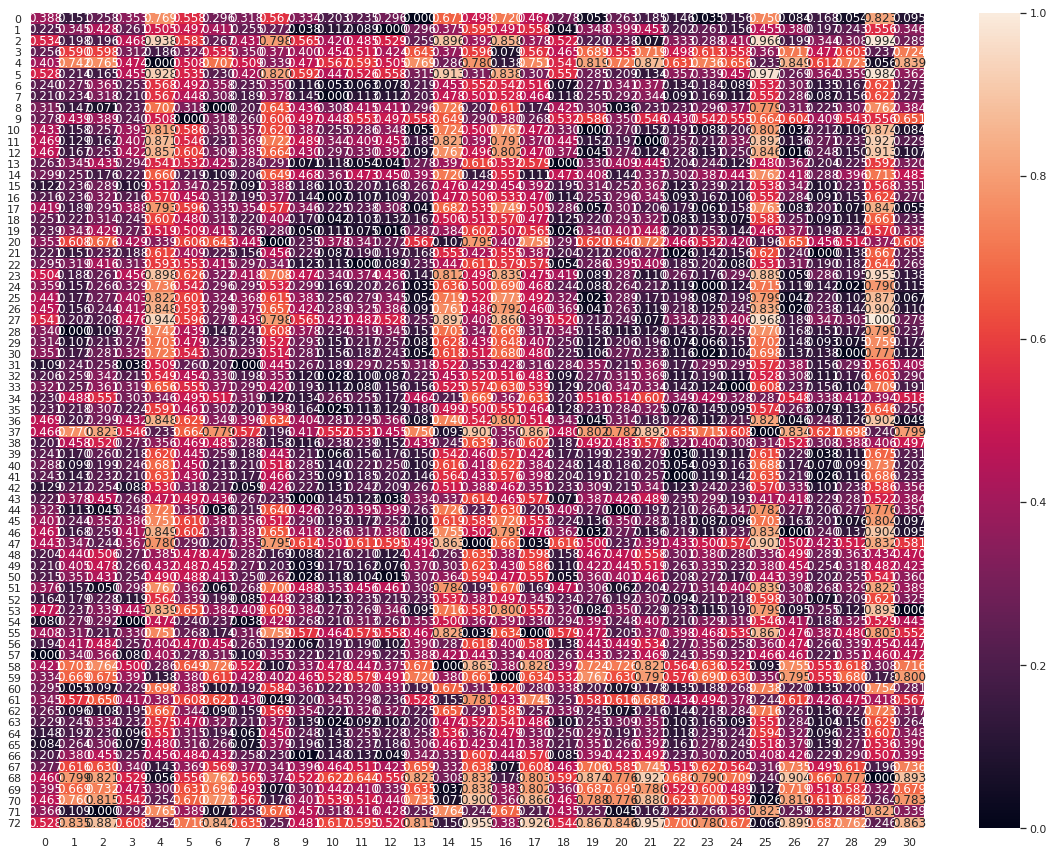

In [33]:
import seaborn as sns; sns.set()
ax = sns.heatmap(D1, annot=True, fmt="0.3f") #[0:10, 0:10]

In [18]:
print(len(cols))
cols

8


array([7, 1, 3, 8, 5, 0, 5, 8])